# Research Paper 1, Experiment 1
#### Univariate Time Series forecating using variation of LSTM

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf

from LSTM_CIFG import LSTM_CIFG
from LSTM_NFG import LSTM_NFG
from LSTM_NIA import LSTM_NIA
from LSTM_NIG import LSTM_NIG
from LSTM_NOA import LSTM_NOA
from LSTM_NOG import LSTM_NOG

from tensorflow.keras.layers import *
from LSTM_PeepHole import PeepholeLSTMCell

from tensorflow.keras.models import Sequential

#from tf.tfa.rnn import PeepholeLSTMCell as LSTM_Peephole

!pip install sktime
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [176]:
df = pd.read_csv('jena_climate_2009_2016.csv')

In [177]:
df.tail()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
420546,31.12.2016 23:20:00,1000.07,-4.05,269.10,-8.13,73.10,4.52,3.30,1.22,2.06,3.30,1292.98,0.67,1.52,240.0
420547,31.12.2016 23:30:00,999.93,-3.35,269.81,-8.06,69.71,4.77,3.32,1.44,2.07,3.32,1289.44,1.14,1.92,234.3
420548,31.12.2016 23:40:00,999.82,-3.16,270.01,-8.21,67.91,4.84,3.28,1.55,2.05,3.28,1288.39,1.08,2.00,215.2
420549,31.12.2016 23:50:00,999.81,-4.23,268.94,-8.53,71.80,4.46,3.20,1.26,1.99,3.20,1293.56,1.49,2.16,225.8
420550,01.01.2017 00:00:00,999.82,-4.82,268.36,-8.42,75.70,4.27,3.23,1.04,2.01,3.23,1296.38,1.23,1.96,184.9


In [178]:
df['date'] = pd.to_datetime(df['Date Time'], infer_datetime_format=True)
df = df[5::6]
df.set_index('date',inplace=True)

In [179]:
df.shape, df['T (degC)'].describe()

((70091, 15),
 count    70091.000000
 mean         9.450482
 std          8.423384
 min        -22.760000
 25%          3.350000
 50%          9.410000
 75%         15.480000
 max         37.280000
 Name: T (degC), dtype: float64)

<Axes: xlabel='date'>

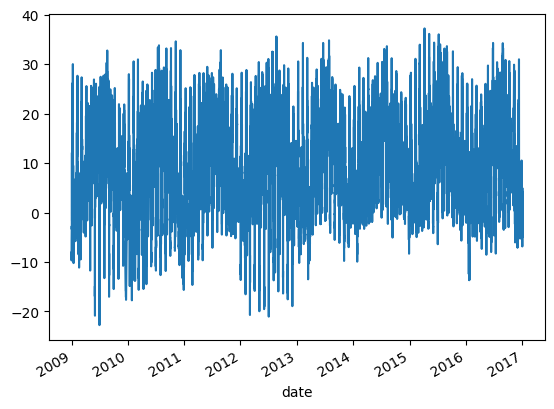

In [180]:
df['T (degC)'].plot()

In [181]:
df.loc['2014'].shape, df.columns

((8774, 15),
 Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
        'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
        'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
        'wd (deg)'],
       dtype='object'))

In [182]:
columns = ['T (degC)']

In [183]:
## For Scalling Data
temp = df['T (degC)']

scaler = MinMaxScaler()

temp_scaled = scaler.fit_transform(temp.to_numpy().reshape(-1, 1))
scalled_df = pd.DataFrame(data =temp_scaled.reshape(1,-1)[0], index= temp.index, columns =columns )#temp_scaled.reshape(1,-1)


In [184]:
train_df = df[columns].loc['2009':'2014']
val_df = df[columns].loc['2015']
test_df =df[columns].loc['2015']

<ipython-input-184-4a53ff61f383>:1: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  train_df = df[columns].loc['2009':'2014']


(<Axes: xlabel='date'>, <Axes: xlabel='date'>, <Axes: xlabel='date'>)

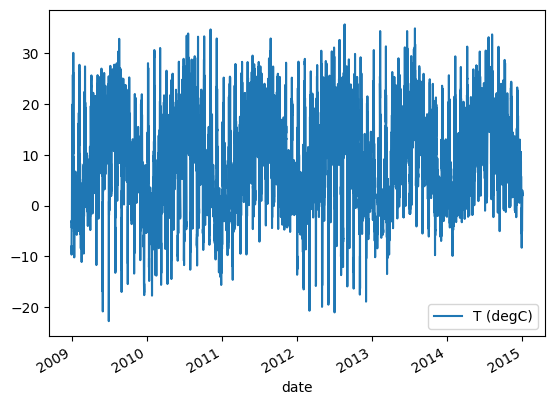

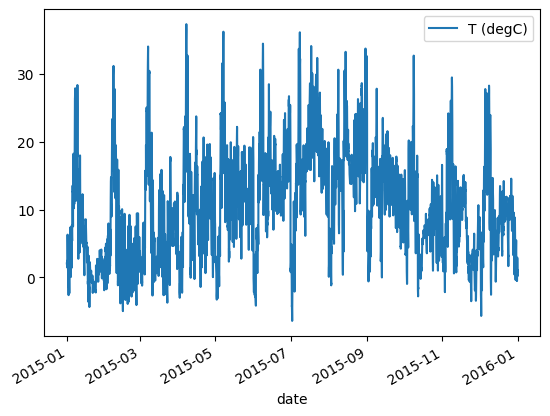

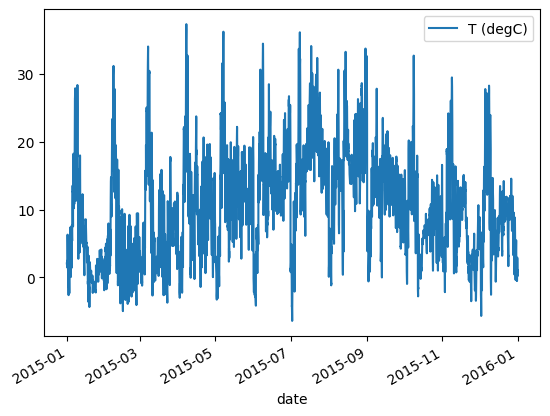

In [185]:
train_df.plot(),val_df.plot(),test_df.plot()

In [186]:
num_features  = len(columns)
input_width = 24
label_width = 1
OUT_STEPS = 1
shift = 1

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24]
Label column name(s): ['T (degC)']

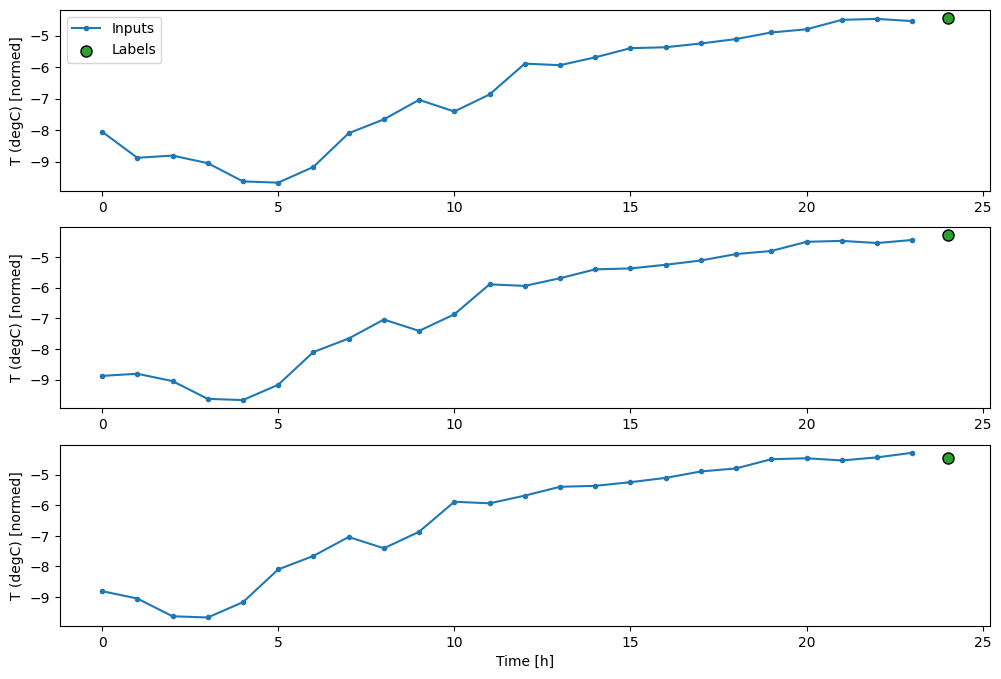

In [187]:
from WindowGenerator import WindowGenerator

single_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=1,
                               train_df=train_df, val_df=val_df, test_df=test_df,
                               label_columns=['T (degC)'])

single_window.plot()
single_window

In [188]:
train_performance = {}
val_performance = {}
test_performance = {}
result_df = pd.DataFrame()
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredEMearror()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history

def evaluate_model(predictions, actuals,y_train):
  '''
  predictions: 1d array
  actuals: 1d array
  y_train: training values for evaluating naive forecast
  '''
  if(len(predictions)!=len(actuals)):
    return "Error: lenght of predition and actuals not equal"
  rmse = np.sqrt(np.average((predictions-actuals)**2))
  mae  = np.average(abs(predictions-actuals))
  mse  = np.average(((predictions-actuals)**2))
  mase = mean_absolute_scaled_error(actuals, predictions, y_train=y_train)
  evaluation = {}

  evaluation['rmse'] = rmse
  evaluation['mae']= mae
  evaluation['mse'] = mse
  evaluation['mase'] = mase
  return evaluation

In [189]:
#model  = ['LSTM', 'LSTMP', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG', 'PeepholeLSTMCell']

models = [LSTM, GRU, LSTM_CIFG, LSTM_NFG, LSTM_NIA, LSTM_NIG, LSTM_NOA, LSTM_NOG,PeepholeLSTMCell ]
models_name = np.array(['LSTM', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG','PeepholeLSTMCell' ])
dataset_name = ['Train', 'Val', 'Test']

In [190]:
def create_compile_fit_model(layer_name,  window, patience=2):
  if layer_name==LSTM:
    layer_name = tf.keras.layers.LSTM(64, return_sequences=False)  
  elif layer_name==GRU:
    layer_name =  tf.keras.layers.GRU(64, return_sequences=False)
  else:
    layer_name = tf.keras.layers.RNN(layer_name(64), return_sequences=False)
  
  model = tf.keras.Sequential([
    layer_name,
    tf.keras.layers.Dense(8,'relu'),
    tf.keras.layers.Dense(OUT_STEPS*num_features),
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
    ])

  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping], verbose=0)
  return history,model

def evaluate_model(predictions, actuals,y_train):
  '''
  predictions: 1d array
  actuals: 1d array
  y_train: training values for evaluating naive forecast
  '''
  if(len(predictions)!=len(actuals)):
    return "Error: lenght of predition and actuals not equal"
  rmse = np.sqrt(np.average((predictions-actuals)**2))
  mae  = np.average(abs(predictions-actuals))
  mse  = (np.average((predictions-actuals)**2))
  mase = mean_absolute_scaled_error(actuals, predictions, y_train=y_train)
  evaluation = {}

  evaluation['rmse'] = rmse
  evaluation['mae']= mae
  evaluation['mse']= mse
  evaluation['mase'] = mase
  return evaluation

def evaluate_all_model(models, window, y_train):
  # Result for Train Data
  #results_rmse = []
  #results_mape = []
  #results_mase = []
  result_df =pd.DataFrame(columns = ['rmse','mae','mse','mase'])
  ind = []

  for model_name,model in models.items():
    predictions = model.predict(window.train).ravel()
    actuals     = train_df['T (degC)'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['T (degC)'].values)
    
    result_df   = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    # Result for Val Data
    predictions = model.predict(window.val).ravel()
    actuals     = val_df['T (degC)'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['T (degC)'].values)
    #print(model_name,result_df)
    result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    # Result for Test Data
    predictions = model.predict(window.test).ravel()
    actuals     = test_df['T (degC)'][24:].values
    evalution   = evaluate_model(predictions,actuals,train_df['T (degC)'].values)
    result_df = pd.concat([result_df,pd.DataFrame(evalution, index=[0])],ignore_index=True)
    ind.append(model_name)

    
  
  return result_df,ind


In [191]:
#train_df[columns]

In [ ]:
%%time
models_all = {}
history_all = {}
for model, model_name in zip(models, models_name):
  history,model = create_compile_fit_model(model,single_window)
  models_all[model_name] = model
  history_all[model_name] = history

built
built
built








built
built


In [ ]:
train_df.shape,val_df.shape,train_df.shape

In [ ]:
%%time
result_df,ind = evaluate_all_model(models_all, single_window, train_df['T (degC)'].values)
result_df.index = ind
result_df

In [ ]:
result_df[0::3].sort_values(['mae'])

In [ ]:
result_df[1::3].sort_values(['mae'])

In [ ]:
result_df[2::3].sort_values(['mae'])

In [ ]:
plt.scatter(result_df['rmse'][2::3], result_df['mae'][2::3])

In [ ]:
models_name_for_charts = ['LSTM', 'GRU', 'CIFG', 'NFG', 'NIA', 'NIG', 'NOA', 'NOG',
       'Peephole']

In [ ]:
barWidth = 0.25

models_n1 = np.arange(len(models_name_for_charts))
models_n2 = [x + barWidth for x in models_n1]
models_n3 = [x + barWidth for x in models_n2]

eval_matrix = {"RMSE":result_df['rmse'], "MAE":result_df['mae']}


for key, m in eval_matrix.items():
  values1 = list(m[0::3].values.reshape(1,-1))
  values2 = list(m[1::3].values.reshape(1,-1))
  values3 = list(m[2::3].values.reshape(1,-1))

  # creating the bar plot
  fig = plt.figure(figsize = (10, 5))
  h1 = plt.bar(models_n1, values1[0], width=0.25, )
  h2 = plt.bar(models_n2, values2[0], width=0.25, )
  h3 = plt.bar(models_n3, values3[0], width=0.25, )
  
  #plt.bar_label(h1,values1)

  plt.xticks([r + barWidth for r in range(len(models_name_for_charts))],models_name_for_charts)
  #plt.yticks(np.arange(0,50,10),[i for i in np.arange(0,50,10)])
  #plt.yticks([10, 20, 30], ['January', 'February', 'March'],
  #     rotation=45) 
  #plt.bar_label("1")
  plt.legend(dataset_name)
  
  plt.xlabel("Name of LSTM Varient")
  plt.ylabel(key)
  plt.title(key+" comparison of Temprature forecasting on Jena Climate Dataset")
  plt.savefig(key+'.png', dpi=300)
  plt.show()


In [ ]:
fig, axs = plt.subplots(3, 3, figsize=(8, 7), layout='constrained')
for ax, model_name in zip(axs.flat, history_all):
    ax.set_title(f'LSTM Varient Name : {model_name}', fontsize=10, )
    
    ax.plot(np.array(history_all[model_name].history['val_loss']))
    ax.plot(np.array(history_all[model_name].history['loss']))
    
    ax.legend(['val_loss','training_loss'], fontsize = 7)
    fig.supxlabel('Number of Epoch')
    fig.supylabel('Mean Squred Error')
    plt.savefig("all_jena_weather.png", dpi=300)


In [ ]:
l=[]
for model_name in history_all:
  #print(model_name)
  plt.plot(history_all[model_name].history['loss']) 
  l.append(model_name+" ("+str(len(history_all[model_name].history['loss']))+")")

plt.legend(l)
plt.title("Training Loss for Home Appliances Energy Usage")
plt.xlabel("Epoch")
plt.ylabel("Loss: Root Mean Squred Error")
#plt.savefig("loss.png", dpi=300)